In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, make_scorer
from statistics import mean
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd

In [40]:
SAMPLING = True

X_test_full = pd.read_csv("./preprocessed/mergedTestData.csv")

algorithms = []
metrics = {}
plots_data = {}

scoring = {
  "precision_score": make_scorer(precision_score, zero_division=0),
  "recall_score": "recall",
  "roc_auc_score": "roc_auc",
  "f1_score": "f1",
  "accuracy_score": "accuracy",
}

def run_model(pipeline, param_grid, X_train, y_train, X_test_pred, clfName, X_test=[], y_test=[]):
  global algorithms, metrics, plots_data
  
  # Define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

  grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
    scoring=scoring, n_jobs=-1, cv=cv, refit="roc_auc_score")

  grid_result = grid.fit(X_train, y_train)
  print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

  # Evaluate the model
  p_pred = grid_result.predict_proba(X_test_pred)

  # ROC Curve & PR 
  estimator = grid_result.best_estimator_

  if SAMPLING:
    plots_data[clfName] = [estimator, X_test, y_test]
    
    RocCurveDisplay.from_estimator(estimator, X_test, y_test)
    PrecisionRecallDisplay.from_estimator(estimator, X_test, y_test)
  else:
    plots_data[clfName] = [estimator, X_train, y_train]
    
    RocCurveDisplay.from_estimator(estimator, X_train, y_train)
    PrecisionRecallDisplay.from_estimator(estimator, X_train, y_train)
  
  mean_fit_time = mean(grid_result.cv_results_.get('mean_fit_time'))
  mean_accuracy_score = mean(grid_result.cv_results_.get('mean_test_accuracy_score'))
  mean_precision_score = mean(grid_result.cv_results_.get('mean_test_precision_score'))
  mean_recall_score = mean(grid_result.cv_results_.get('mean_test_recall_score'))
  mean_roc_auc_score = mean(grid_result.cv_results_.get('mean_test_roc_auc_score'))
  mean_f1_score = mean(grid_result.cv_results_.get('mean_test_f1_score'))

  algorithms.append(clfName)
  metrics[clfName] = {}
  
  metrics[clfName]["fit_time"] = mean_fit_time
  metrics[clfName]["accuracy"] = mean_accuracy_score
  metrics[clfName]["precision"] = mean_precision_score
  metrics[clfName]["recall"] = mean_recall_score
  metrics[clfName]["roc_auc"] = mean_roc_auc_score
  metrics[clfName]["f1"] = mean_f1_score

  print("----------------- Metrics: -----------------")
  print("Mean Fit Time: " + str(mean_fit_time))
  print("Mean Accuracy Score: " + str(mean_accuracy_score))
  print("Mean Precision Score: " + str(mean_precision_score))
  print("Mean Recall Score: " + str(mean_recall_score))
  print("Mean Roc-Auc Score: " + str(mean_roc_auc_score))
  print("Mean F1 Score: " + str(mean_f1_score))

  resultData = {'Id': X_test_full['loan_id'], 'Predicted': p_pred[:,1]}
  result = pd.DataFrame(data=resultData)
  return result

def encode_df(df):
  columnsToEncode = list(df.select_dtypes(include=['object']))
  le = LabelEncoder()
  for feature in columnsToEncode:
      try:
          df[feature] = le.fit_transform(df[feature])
      except:
          print('Error encoding ' + feature)
  return df

def load_data():
  X_train_full = pd.read_csv("./preprocessed/mergedTrainData.csv")

  # Obtain target and predictors
  # features = ['reached_negative_balance', 'RAB_mean', 'RAB_min', 'ratio_RAB', 'RAB_max', 'credit_ratio', 'withdrawal_ratio', 'IC_mean', 'balance_min', 'RAB_sum', 'mean_trans_profit', 'RAB', 'balance_mean', 'ratio_CC', 'CC_std', 'IC_min', 'CC_max', 'ratio_IC']
 
  # Used for best submission
  features = ['reached_negative_balance', 'RAB_mean', 'ratio_RAB', 'credit_ratio', 'balance_min', 'RAB_sum', 'mean_trans_profit', 'balance_mean', 'ratio_CC', 'CC_std', 'IC_min', 'CC_max', 'ratio_IC', 'withdrawal_max', 'WC_max', 'last_balance', 'CAB_mean']
  # features = ['reached_negative_balance', 'RAB_mean', 'RAB_min', 'ratio_RAB', 'RAB_max', 'credit_ratio', 'withdrawal_ratio', 'IC_mean', 'balance_min', 'RAB_sum', 'mean_trans_profit', 'RAB', 'balance_mean', 'ratio_CC', 'CC_std', 'IC_min', 'CC_max', 'ratio_IC', 'withdrawal_max', 'WC_max']

  X_train = X_train_full[features]
  X_test_pred = X_test_full[features]
  
  # Positive class now is 1 and negative class now is 0
  X_train_full.loc[X_train_full["status"] == 1, "status"] = 0
  X_train_full.loc[X_train_full["status"] == -1, "status"] = 1
  
  y_train = X_train_full.status
  
  if SAMPLING:
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)
    return [X_train, X_test, X_test_pred, y_train, y_test]
  else:
    return [X_train, X_test_pred, y_train]

## Logistic Regression
Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

------- WITH UNDERSAMPLING -------
Best: 0.908029 using {'classification__C': 0.05, 'classification__class_weight': 'balanced', 'classification__penalty': 'l2', 'classification__solver': 'liblinear', 'under__sampling_strategy': 0.2}
----------------- Metrics: -----------------
Mean Fit Time: 0.0468265690311553
Mean Accuracy Score: 0.8441323038877387
Mean Precision Score: 0.5199637602256649
Mean Recall Score: 0.7244444444444444
Mean Roc-Auc Score: 0.8900002204585538
Mean F1 Score: 0.5604190961155247


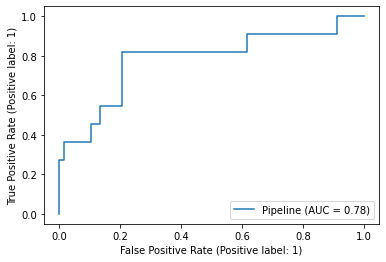

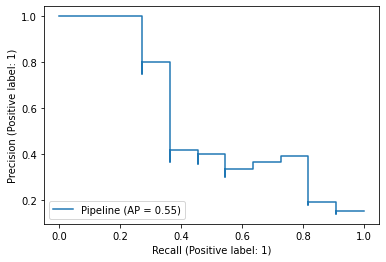

In [41]:
# Load data
if SAMPLING: 
  [X_train, X_test, X_test_pred, y_train, y_test] = load_data() 
  X_test = encode_df(X_test)
else:
  [X_train, X_test_pred, y_train] = load_data()

X_train = encode_df(X_train)

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('scaler', StandardScaler()), ('classification', LogisticRegression(random_state=0, max_iter=10000))])

param_grid = {'under__sampling_strategy': [0.2, 0.25, 0.5, 0.75, 0.9, 0.99, 'majority'],
          'classification__penalty': ['l2'],
          'classification__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
          'classification__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
          'classification__class_weight': ["balanced", None]}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "LogisticRegression_Undersampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/logisticRegressionUndersampling.csv", index=None)

------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------
Best: 0.912011 using {'classification__C': 0.01, 'classification__class_weight': None, 'classification__penalty': 'l2', 'classification__solver': 'liblinear'}
----------------- Metrics: -----------------
Mean Fit Time: 0.023583076265123154
Mean Accuracy Score: 0.8688425925925927
Mean Precision Score: 0.5853686853270187
Mean Recall Score: 0.5867592592592593
Mean Roc-Auc Score: 0.9021949955908289
Mean F1 Score: 0.5164331085581085


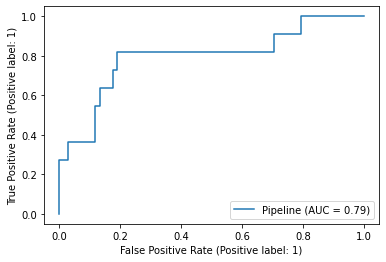

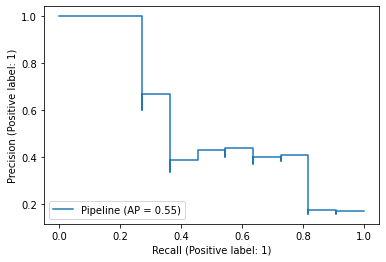

In [42]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")
pipeline = Pipeline([('scaler', StandardScaler()), ('classification', LogisticRegression(random_state=0, max_iter=10000))])

param_grid = {'classification__penalty': ['l2'],
          'classification__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
          'classification__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
          'classification__class_weight': ["balanced", None]}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "LogisticRegression", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/logisticRegression.csv", index=None)


In [43]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('scaler', StandardScaler()), ('classification', LogisticRegression(random_state=0, max_iter=10000))])

weights = list(np.linspace(0.2, 0.9, 5)) + ['minority']
param_grid = {
        'smote__sampling_strategy': weights,
        'classification__penalty': ['l2'],
        'classification__C': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
        'classification__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
        'classification__class_weight': ["balanced", None]}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "LogisticRegression_Oversampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/logisticRegressionWithSMOTE.csv", index=None)

------- WITH OVERSAMPLING -------


exception calling callback for <Future at 0x7f4abc735940 state=finished returned list>
Traceback (most recent call last):
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 531, in apply_async
    future = self._workers.submit(SafeFuncti

KeyboardInterrupt: 

# Random Forest

------- WITH UNDERSAMPLING -------
Best: 0.916201 using {'classification__class_weight': None, 'classification__criterion': 'gini', 'classification__max_features': 'sqrt', 'classification__n_estimators': 250, 'under__sampling_strategy': 0.2}
----------------- Metrics: -----------------
Mean Fit Time: 0.7346460825867123
Mean Accuracy Score: 0.8676938657407407
Mean Precision Score: 0.58802387525631
Mean Recall Score: 0.7040972222222222
Mean Roc-Auc Score: 0.9019278181951793
Mean F1 Score: 0.5961905458399912


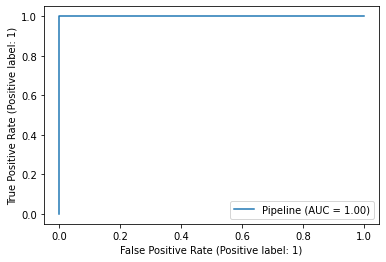

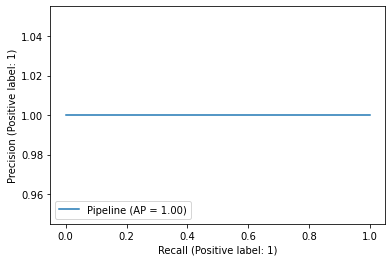

In [ ]:
# https://stackoverflow.com/questions/30814231/using-the-predict-proba-function-of-randomforestclassifier-in-the-safe-and-rig
# https://rpmcruz.github.io/machine%20learning/2018/02/09/probabilities-trees.html

# Load data
if SAMPLING: 
  [X_train, X_test, X_test_pred, y_train, y_test] = load_data() 
  X_test = encode_df(X_test)
else:
  [X_train, X_test_pred, y_train] = load_data()

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('classification', RandomForestClassifier(random_state=0))])

param_grid = {'under__sampling_strategy': [0.2, 0.5, 0.75, 0.9],
            'classification__n_estimators': [50, 150, 250],
            'classification__max_features': ['sqrt', 'auto'],
            'classification__criterion': ['gini', 'entropy'],
            'classification__class_weight': ["balanced", "balanced_subsample", None],}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "RandomForest_Undersampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/randomForestUndersampling.csv", index=None)

------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------
Best: 0.907216 using {'classification__class_weight': 'balanced', 'classification__criterion': 'entropy', 'classification__max_features': 'sqrt', 'classification__n_estimators': 150}
----------------- Metrics: -----------------
Mean Fit Time: 0.8779041171073914
Mean Accuracy Score: 0.9131642512077296
Mean Precision Score: 0.7672310405643739
Mean Recall Score: 0.44537037037037036
Mean Roc-Auc Score: 0.8953294018224573
Mean F1 Score: 0.5394944150499705


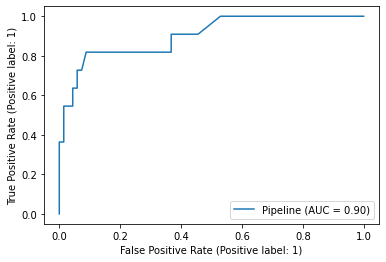

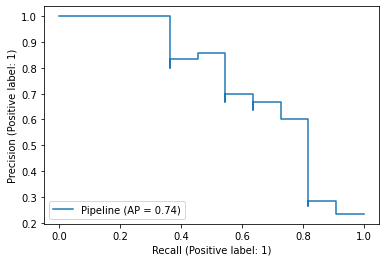

In [46]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")
param_grid = {'classification__n_estimators': [50, 150, 250],
              'classification__max_features': ['sqrt', 'auto'],
              'classification__criterion': ['gini', 'entropy'],
              'classification__class_weight': ["balanced", "balanced_subsample", None],
            }

pipeline = Pipeline([('classification', RandomForestClassifier(random_state=0))])
results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "RandomForest", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/randomForest.csv", index=None)

------- WITH OVERSAMPLING -------
Best: 0.919831 using {'classification__class_weight': 'balanced', 'classification__criterion': 'gini', 'classification__max_features': 'sqrt', 'classification__n_estimators': 250, 'smote__sampling_strategy': 0.55}
----------------- Metrics: -----------------
Mean Fit Time: 0.7823650542232725
Mean Accuracy Score: 0.9131228843090401
Mean Precision Score: 0.7633940819126004
Mean Recall Score: 0.5911111111111111
Mean Roc-Auc Score: 0.9088946146874388
Mean F1 Score: 0.6380671797338464


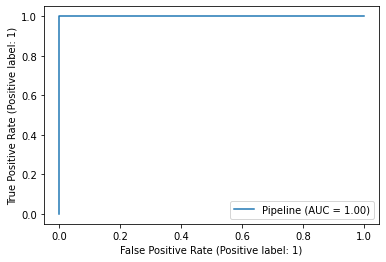

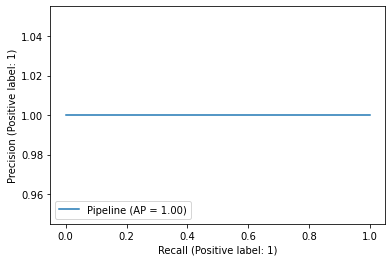

In [ ]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('classification', RandomForestClassifier(random_state=0))])

weights = list(np.linspace(0.2, 0.9, 5)) + ['minority']
param_grid['smote__sampling_strategy'] = weights
results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "RandomForest_Oversampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/randomForestWithSMOTE.csv", index=None)

# SVM
Applying Min-Max Scaling so that values are normalized (0-1).

In [45]:
def min_max_scaling(df, numeric_columns):
  # copy the dataframe
  df_norm = df.copy()
  # apply min-max scaling
  for column in numeric_columns:
      df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
      
  return df_norm


------- WITH UNDERSAMPLING -------
Best: 0.909398 using {'classification__C': 0.1, 'classification__gamma': 0.1, 'classification__kernel': 'rbf', 'under__sampling_strategy': 0.5}
----------------- Metrics: -----------------
Mean Fit Time: 0.04009893866947719
Mean Accuracy Score: 0.8226840062111802
Mean Precision Score: 0.3468148473748456
Mean Recall Score: 0.4609484126984127
Mean Roc-Auc Score: 0.8555900699168556
Mean F1 Score: 0.34457450016316465


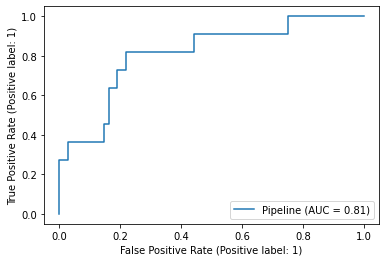

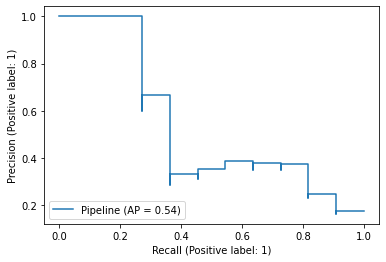

In [48]:
# https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

# Load data
numeric_features = list(X_train.select_dtypes(include=['int64', 'float64']))

if SAMPLING: 
  [X_train, X_test, X_test_pred, y_train, y_test] = load_data() 
  X_test = min_max_scaling(X_test, numeric_features)
else:
  [X_train, X_test_pred, y_train] = load_data()

X_train = min_max_scaling(X_train, numeric_features)

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('classification', SVC(probability=True, random_state=0))])

param_grid = {'under__sampling_strategy': [0.2, 0.25, 0.5, 0.75, 0.9, 0.99, 'majority'],
            'classification__C': [0.1, 1, 10, 100, 1000],
            'classification__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'classification__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "SVM_Undersampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/SVMUndersampling.csv", index=None)


------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------
Best: 0.868979 using {'classification__C': 10, 'classification__gamma': 0.1, 'classification__kernel': 'rbf'}
----------------- Metrics: -----------------
Mean Fit Time: 0.04450844717025757
Mean Accuracy Score: 0.7263565188172043
Mean Precision Score: 0.3370589583655258
Mean Recall Score: 0.7957333333333333
Mean Roc-Auc Score: 0.8384342813051147
Mean F1 Score: 0.45714686109051716


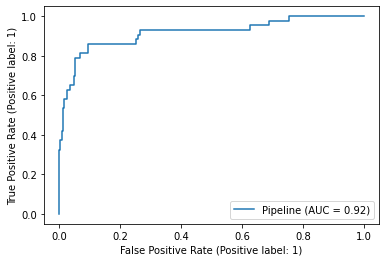

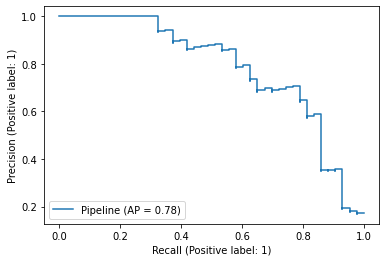

In [ ]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")

clf = Pipeline([('classification', SVC(probability=True, random_state=0))])

param_grid = {'classification__C': [0.1, 1, 10, 100, 1000],
              'classification__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'classification__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}


results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "SVM", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/SVM.csv", index=None)

------- WITH OVERSAMPLING -------
Best: 0.891966 using {'classification__C': 0.1, 'classification__gamma': 1, 'classification__kernel': 'rbf', 'smote__sampling_strategy': 0.375}
----------------- Metrics: -----------------
Mean Fit Time: 0.20916470877329507
Mean Accuracy Score: 0.8477332549283154
Mean Precision Score: 0.3920610340231064
Mean Recall Score: 0.461675
Mean Roc-Auc Score: 0.8507391754850089
Mean F1 Score: 0.37545020695050874


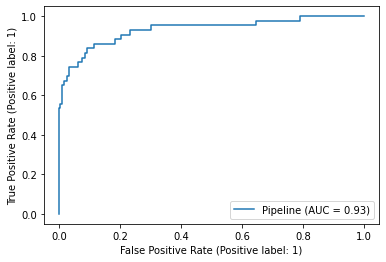

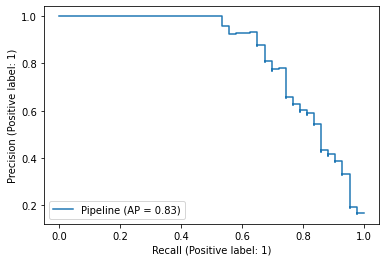

In [ ]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('classification', SVC(probability=True, random_state=0))])

weights = list(np.linspace(0.2, 0.9, 5)) + ['minority']
param_grid['smote__sampling_strategy'] = weights

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "SVM_Oversampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/SVMWithSMOTE.csv", index=None)

# Light GBM

------- WITH UNDERSAMPLING -------
Best: 0.880357 using {'classifier__learning_rate': 0.01, 'classifier__max_depth': 25, 'classifier__n_estimators': 110, 'classifier__num_leaves': 10, 'under__sampling_strategy': 0.2}
----------------- Metrics: -----------------
Mean Fit Time: 0.06725912456527168
Mean Accuracy Score: 0.8153834541062802
Mean Precision Score: 0.40653275014896745
Mean Recall Score: 0.5577932098765432
Mean Roc-Auc Score: 0.8436233741181658
Mean F1 Score: 0.4182781891581771


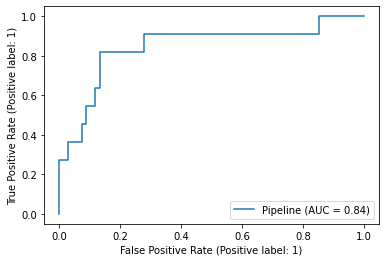

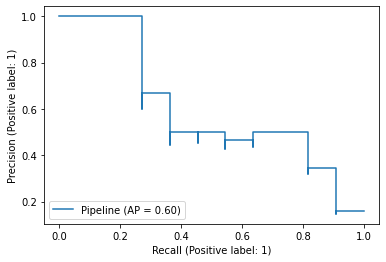

In [47]:
# Load data
if SAMPLING: 
  [X_train, X_test, X_test_pred, y_train, y_test] = load_data() 
  X_test = encode_df(X_test)
else:
  [X_train, X_test_pred, y_train] = load_data()

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('classifier', lgb.LGBMClassifier(random_state=0))])

param_grid = {'under__sampling_strategy': [0.2, 0.25, 0.5, 0.75, 0.9, 'majority'],
              'classifier__max_depth': [25, 50, 75],
              'classifier__learning_rate' : [0.01, 0.05, 0.1],
              'classifier__num_leaves': [int(x) for x in range(10, 100, 50)],
              'classifier__n_estimators': [int(x) for x in range(10, 200, 50)],
             }

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "LightGBM_Undersampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/lightGBMUndersampling.csv", index=None)

------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------
Best: 0.885935 using {'classifier__learning_rate': 0.1, 'classifier__max_depth': 25, 'classifier__n_estimators': 10, 'classifier__num_leaves': 52}
----------------- Metrics: -----------------
Mean Fit Time: 0.06899740320664866
Mean Accuracy Score: 0.8923261088709677
Mean Precision Score: 0.5173578042328042
Mean Recall Score: 0.2827777777777778
Mean Roc-Auc Score: 0.8666468713256907
Mean F1 Score: 0.345015532307199


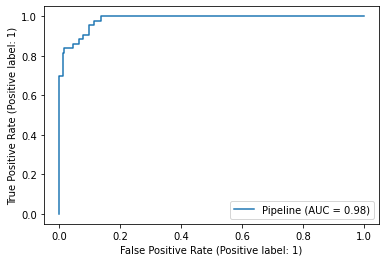

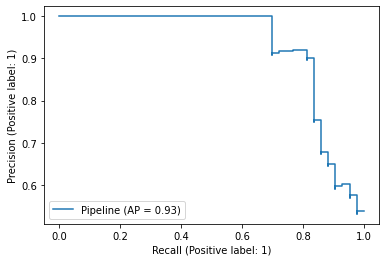

In [ ]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")
pipeline = Pipeline([('classifier', lgb.LGBMClassifier(random_state=0))])

param_grid = {'classifier__max_depth': [25, 50, 75],
              'classifier__learning_rate' : [0.01, 0.05, 0.1],
              'classifier__num_leaves': [int(x) for x in range(2, 100, 50)],
              'classifier__n_estimators': [int(x) for x in range(10, 200, 50)],
             }

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "LightGBM", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/lightGBM.csv", index=None)

------- WITH OVERSAMPLING -------
Best: 0.905589 using {'classifier__learning_rate': 0.01, 'classifier__max_depth': 25, 'classifier__n_estimators': 160, 'classifier__num_leaves': 52, 'smote__sampling_strategy': 0.9}
----------------- Metrics: -----------------
Mean Fit Time: 0.11328534299944654
Mean Accuracy Score: 0.884348398297491
Mean Precision Score: 0.6086296696809844
Mean Recall Score: 0.48842592592592593
Mean Roc-Auc Score: 0.8623934220679013
Mean F1 Score: 0.49647856765060927


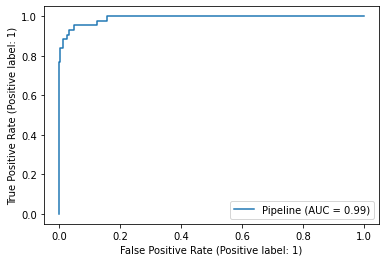

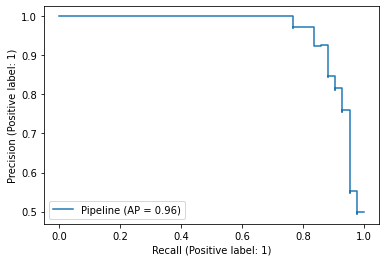

In [ ]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('classifier', lgb.LGBMClassifier(random_state=0))])

weights = list(np.linspace(0.2, 0.9, 5)) + ['minority']
param_grid['smote__sampling_strategy'] = weights

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test_pred, "LightGBM_Oversampling", X_test=X_test, y_test=y_test)
results_df.to_csv("./results/lightGBMSMOTE.csv", index=None)

# Barplots of all algorithms

In [ ]:
def algorithms_comparison_plot(algorithms, title, colors, selectedMetric):
  values = [metrics[alg][selectedMetric] for alg in algorithms]

  fig = plt.figure()

  if len(colors) == 3:
    ax = fig.add_axes([0,0,1.25,1])
  else:
    ax = fig.add_axes([0,0,1.75,1])

  ax.bar(algorithms, values, color=colors)
  plt.xlabel("\n\n" + title, fontdict={"weight": "bold"})
  plt.ylabel("\n\nValue", fontdict={"weight": "bold"})
  plt.show()

# Logistic Regression

### F1 Measure

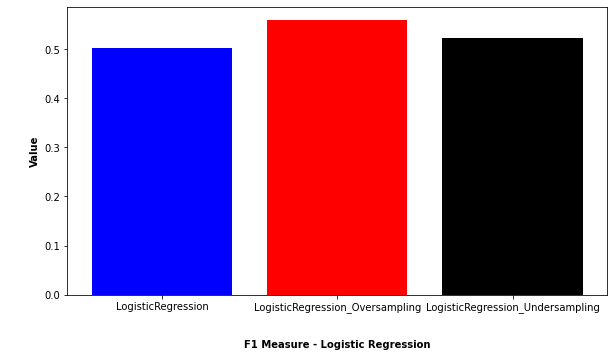

In [ ]:
algorithms_comparison_plot(("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling"), \
  "F1 Measure - Logistic Regression", ['blue', 'red', 'black'], "f1")

### Accuracy

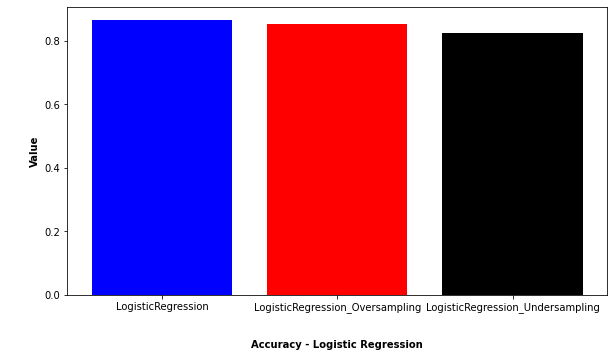

In [ ]:
algorithms_comparison_plot(("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling"), \
  "Accuracy - Logistic Regression", ['blue', 'red', 'black'], "accuracy")

### Precision

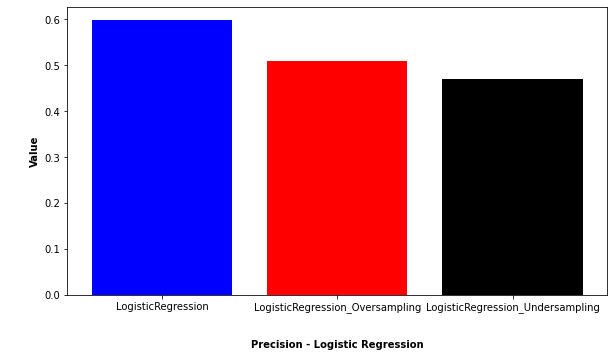

In [ ]:
algorithms_comparison_plot(("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling"), \
  "Precision - Logistic Regression", ['blue', 'red', 'black'], "precision")

### Recall

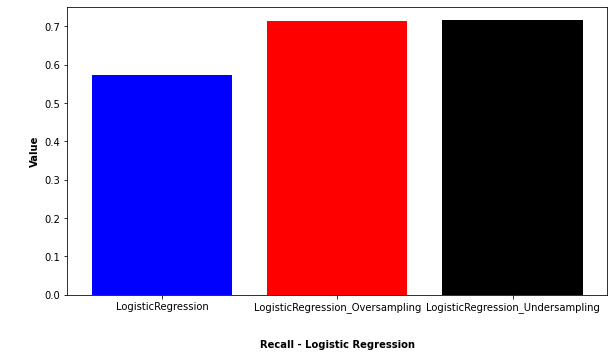

In [ ]:
algorithms_comparison_plot(("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling"), \
  "Recall - Logistic Regression", ['blue', 'red', 'black'], "recall")

### ROC-AUC

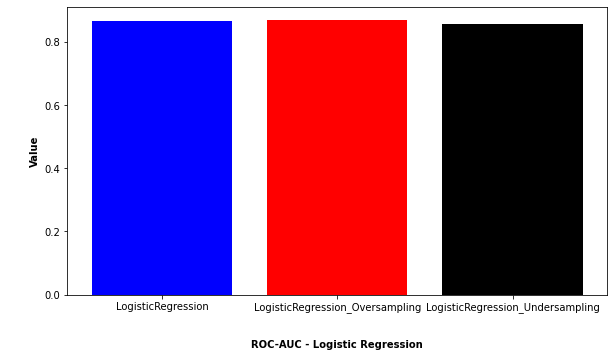

In [ ]:
algorithms_comparison_plot(("LogisticRegression", "LogisticRegression_Oversampling", "LogisticRegression_Undersampling"), \
  "ROC-AUC - Logistic Regression", ['blue', 'red', 'black'], "roc_auc")

# Random Forest

### F1 Measure

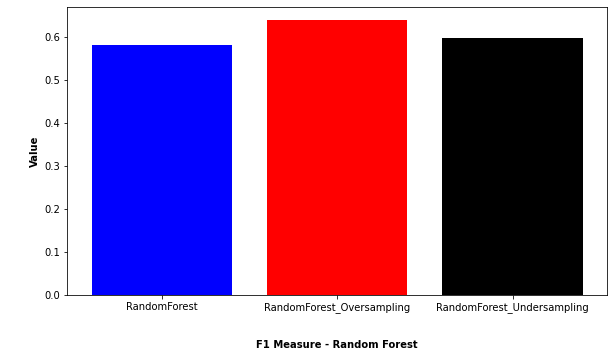

In [ ]:
algorithms_comparison_plot(("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling"), \
  "F1 Measure - Random Forest", ['blue', 'red', 'black'], "f1")

### Accuracy

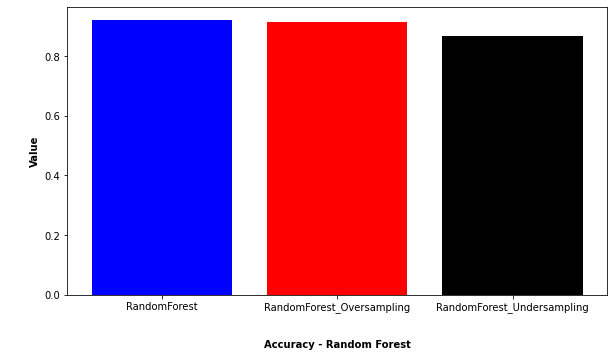

In [ ]:
algorithms_comparison_plot(("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling"), \
  "Accuracy - Random Forest", ['blue', 'red', 'black'], "accuracy")

### Precision

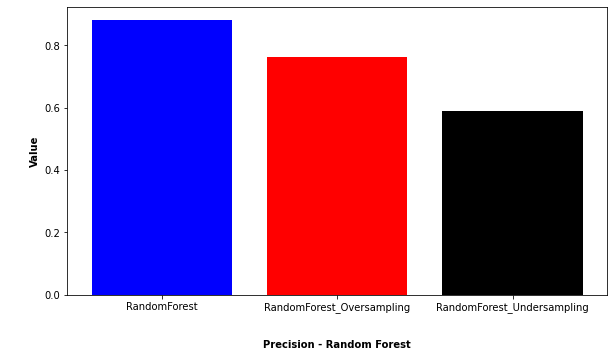

In [ ]:
algorithms_comparison_plot(("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling"), \
  "Precision - Random Forest", ['blue', 'red', 'black'], "precision")

### Recall

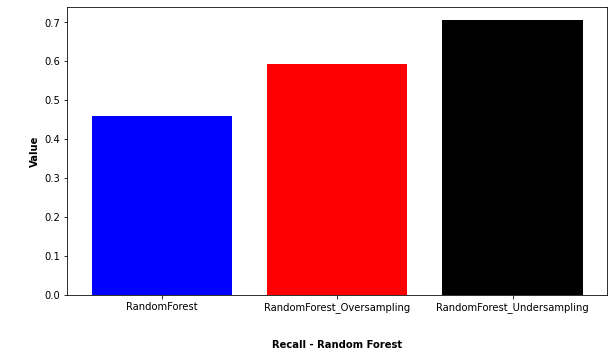

In [ ]:
algorithms_comparison_plot(("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling"), \
  "Recall - Random Forest", ['blue', 'red', 'black'], "recall")

### ROC-AUC

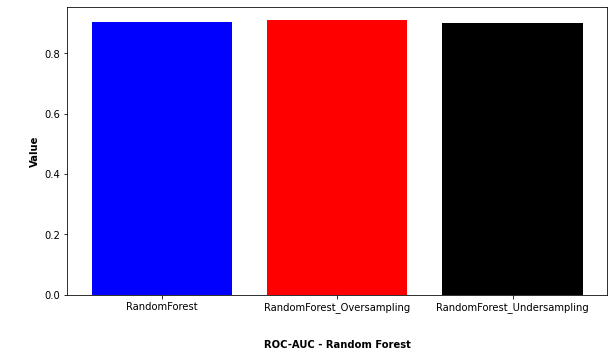

In [ ]:
algorithms_comparison_plot(("RandomForest", "RandomForest_Oversampling", "RandomForest_Undersampling"), \
  "ROC-AUC - Random Forest", ['blue', 'red', 'black'], "roc_auc")

# SVM

### F1 Measure

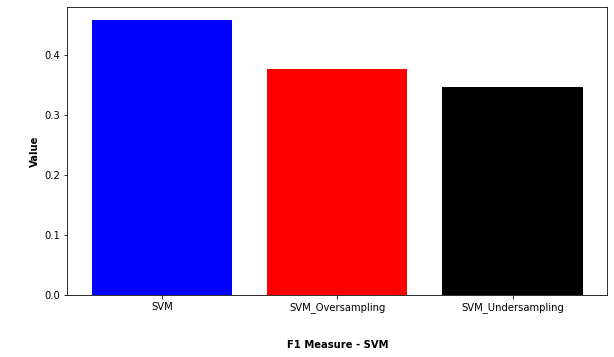

In [ ]:
algorithms_comparison_plot(("SVM", "SVM_Oversampling", "SVM_Undersampling"), \
  "F1 Measure - SVM", ['blue', 'red', 'black'], "f1")

### Accuracy

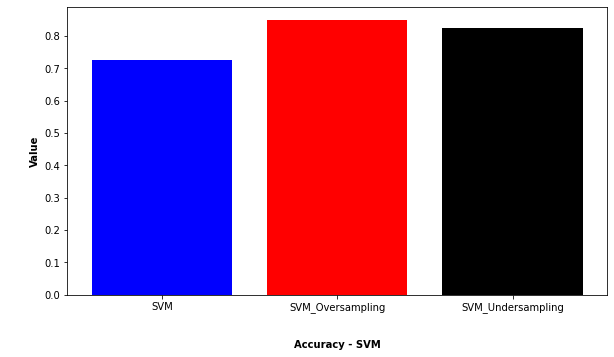

In [ ]:
algorithms_comparison_plot(("SVM", "SVM_Oversampling", "SVM_Undersampling"), \
  "Accuracy - SVM", ['blue', 'red', 'black'], "accuracy")

### Precision

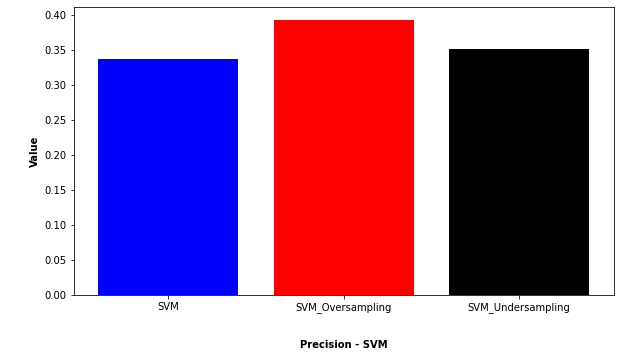

In [ ]:
algorithms_comparison_plot(("SVM", "SVM_Oversampling", "SVM_Undersampling"), \
  "Precision - SVM", ['blue', 'red', 'black'], "precision")

### Recall

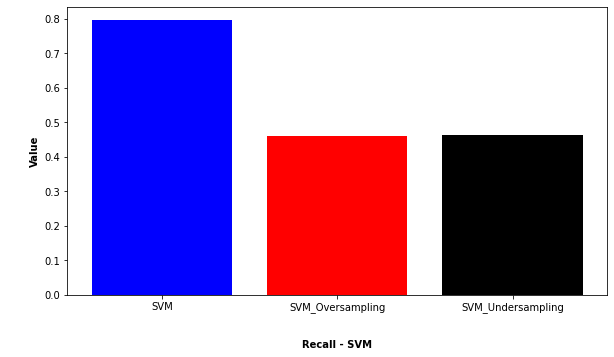

In [ ]:
algorithms_comparison_plot(("SVM", "SVM_Oversampling", "SVM_Undersampling"), \
  "Recall - SVM", ['blue', 'red', 'black'], "recall")

### ROC-AUC

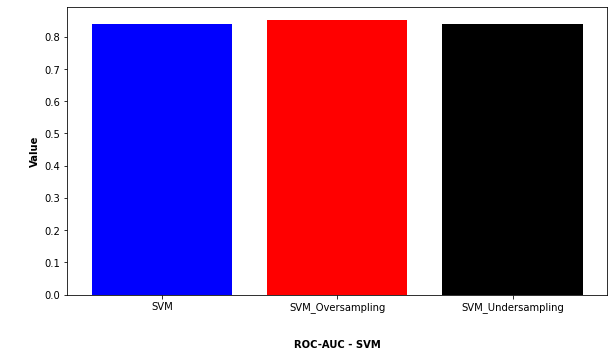

In [ ]:
algorithms_comparison_plot(("SVM", "SVM_Oversampling", "SVM_Undersampling"), \
  "ROC-AUC - SVM", ['blue', 'red', 'black'], "roc_auc")

# Light GBM

### F1 Measure

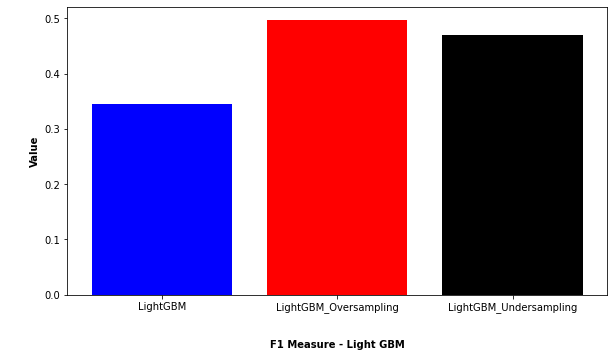

In [ ]:
algorithms_comparison_plot(("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling"), \
  "F1 Measure - Light GBM", ['blue', 'red', 'black'], "f1")

### Accuracy

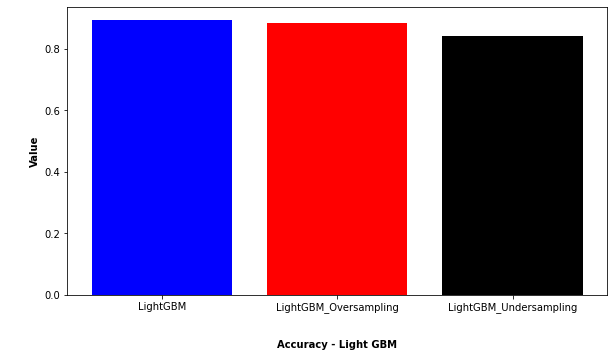

In [ ]:
algorithms_comparison_plot(("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling"), \
  "Accuracy - Light GBM", ['blue', 'red', 'black'], "accuracy")

### Precision

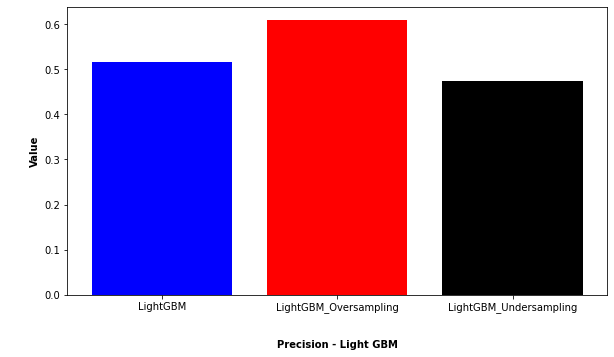

In [ ]:
algorithms_comparison_plot(("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling"), \
  "Precision - Light GBM", ['blue', 'red', 'black'], "precision")

### Recall

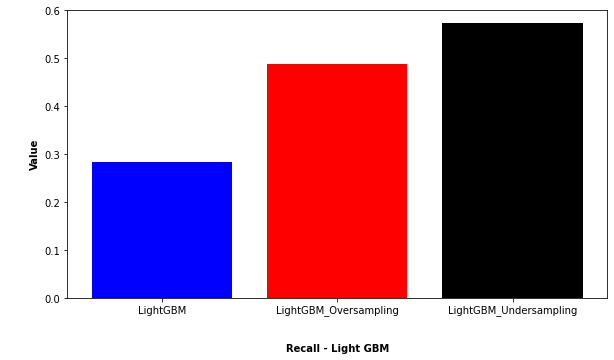

In [ ]:
algorithms_comparison_plot(("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling"), \
  "Recall - Light GBM", ['blue', 'red', 'black'], "recall")

### ROC-AUC

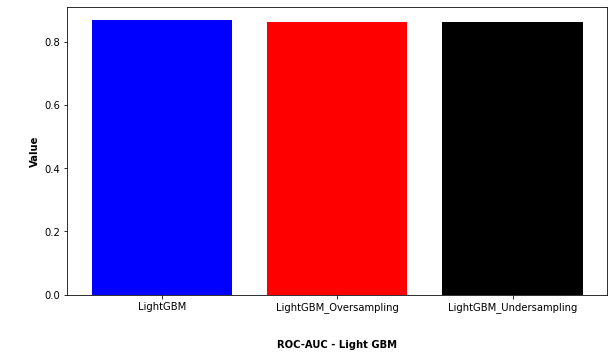

In [ ]:
algorithms_comparison_plot(("LightGBM", "LightGBM_Oversampling", "LightGBM_Undersampling"), \
  "ROC-AUC - Light GBM", ['blue', 'red', 'black'], "roc_auc")

# Comparisons between best algorithms

In [ ]:
best_algorithms = ("LogisticRegression_Oversampling", "RandomForest_Oversampling", "SVM_Undersampling", "LightGBM_Oversampling")
best_colors = ['blue', 'red', 'black', 'green']

### Fit time

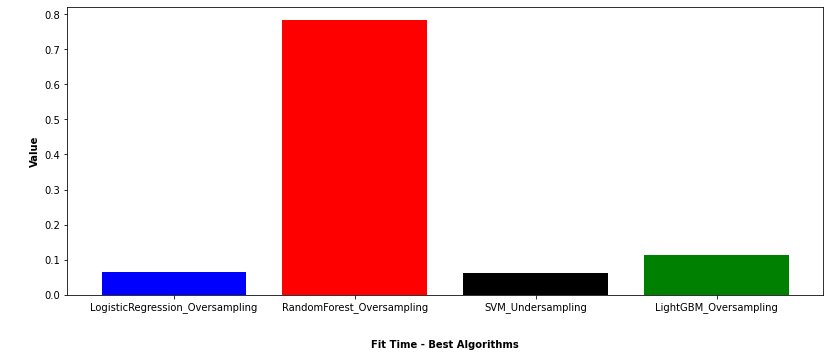

In [ ]:
algorithms_comparison_plot(best_algorithms, "Fit Time - Best Algorithms", best_colors, "fit_time")

### F1 Measure

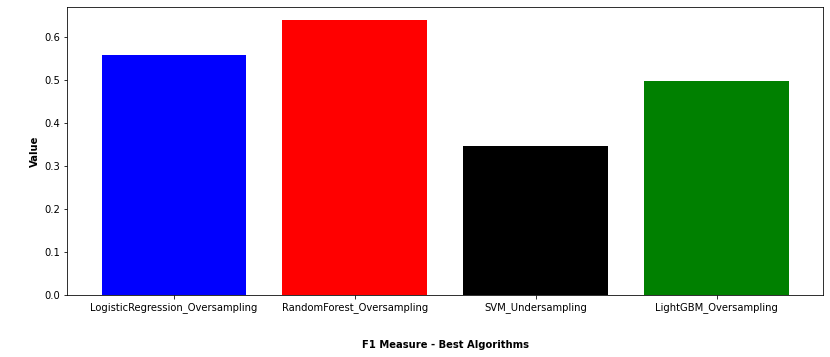

In [ ]:
algorithms_comparison_plot(best_algorithms, "F1 Measure - Best Algorithms", best_colors, "f1")

### Accuracy

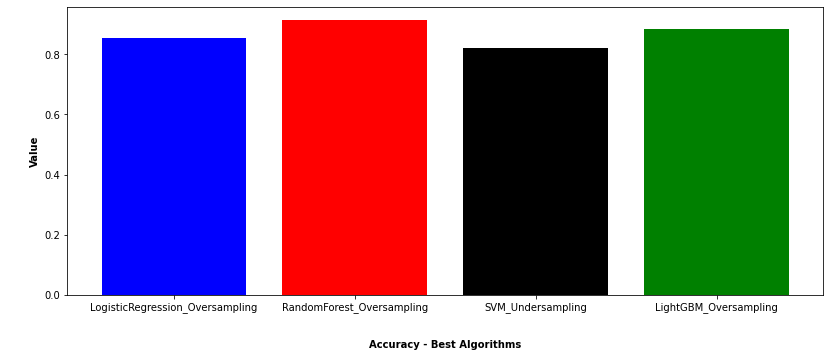

In [ ]:
algorithms_comparison_plot(best_algorithms, "Accuracy - Best Algorithms", best_colors, "accuracy")

### Precision

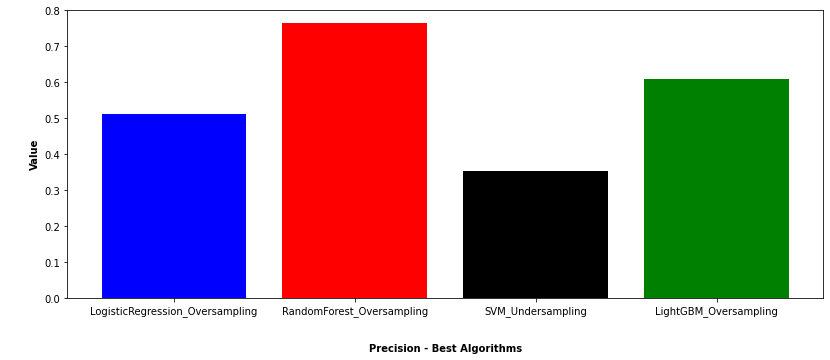

In [ ]:
algorithms_comparison_plot(best_algorithms, "Precision - Best Algorithms", best_colors, "precision")

### Recall

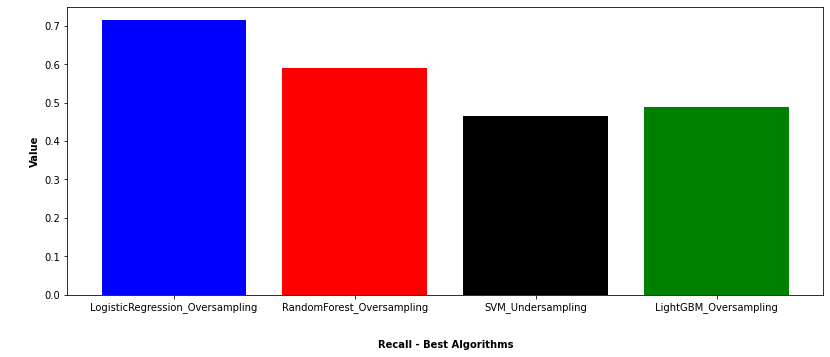

In [ ]:
algorithms_comparison_plot(best_algorithms, "Recall - Best Algorithms", best_colors, "recall")

### ROC-AUC

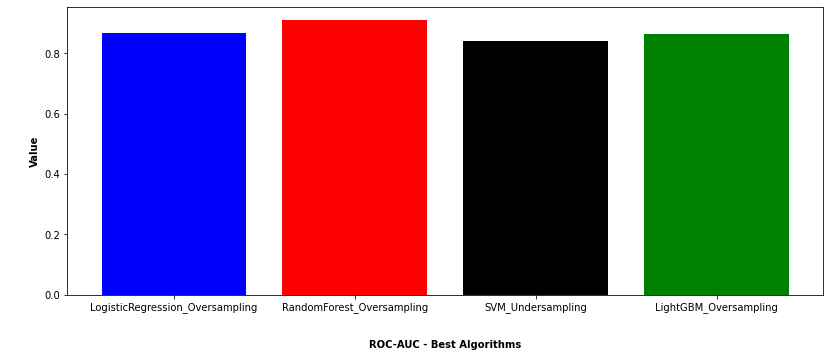

In [ ]:
algorithms_comparison_plot(best_algorithms, "ROC-AUC - Best Algorithms", best_colors, "roc_auc")

# ROC Curve - Best Algorithms

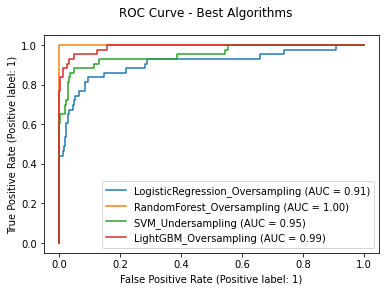

In [ ]:
ax = None
for algorithm in best_algorithms:
  [estimator, X_train_plot, y_train_plot] = plots_data[algorithm]
  if ax is None:
    fig = RocCurveDisplay.from_estimator(estimator, X_train_plot, y_train_plot, name=algorithm)
  else:
    fig = RocCurveDisplay.from_estimator(estimator, X_train_plot, y_train_plot, name=algorithm, ax = fig.ax_)
  ax = fig.ax_

fig.figure_.suptitle("ROC Curve - Best Algorithms")
plt.show() 

# P-R Plot - Best Algorithms

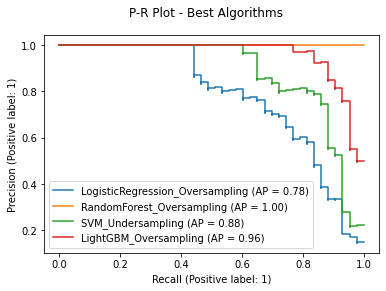

In [ ]:
ax = None
for algorithm in best_algorithms:
  [estimator, X_train_plot, y_train_plot] = plots_data[algorithm]
  if ax is None:
    fig = PrecisionRecallDisplay.from_estimator(estimator, X_train_plot, y_train_plot, name=algorithm)
  else:
    fig = PrecisionRecallDisplay.from_estimator(estimator, X_train_plot, y_train_plot, name=algorithm, ax = fig.ax_)
  ax = fig.ax_

fig.figure_.suptitle("P-R Plot - Best Algorithms")
plt.show() 

# Descriptive Models (Visualization)

`https://towardsdatascience.com pca-using-python-scikit-learn-e653f8989e60`

- Use StandardScaler

- Apply PCA algorithm

In [ ]:
SAMPLING = False
[X_train, _, y_train] = load_data()

pca = PCA(n_components=2)
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
components = pipeline.fit_transform(X_train)
fig = px.scatter(components, x=0, y=1, color=y_train)
fig.show()

In [ ]:
[X_train, _, y_train] = load_data()

pca = PCA(n_components=3)
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
components = pipeline.fit_transform(X_train)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [ ]:
[X_train, _, y_train] = load_data()

n_components = 4
pca = PCA(n_components)
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
components = pipeline.fit_transform(X_train)
labels = {
    str(i): f"PC{i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(n_components),
    color=y_train
)
fig.update_traces(diagonal_visible=False)
fig.show()

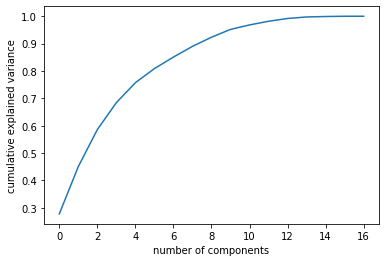

In [ ]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
[X_train, _, y_train] = load_data()

pca = PCA()
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
components = pipeline.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

This curve quantifies how much of the total, 17-dimensional variance is contained within the first N components. For example, we see that with the digits the first 4 components contain approximately 75% of the variance, while you need around 12 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 7 components to retain 90% of the variance. Looking at this plot for a high-dimensional dataset can help understand the level of redundancy present in multiple observations.